<a href="https://colab.research.google.com/github/Aman2000102/machineLearning/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d anaselmasry/covid19normalpneumonia-ct-images

Dataset URL: https://www.kaggle.com/datasets/anaselmasry/covid19normalpneumonia-ct-images
License(s): copyright-authors
100% 933M/936M [00:13<00:00, 106MB/s]
100% 936M/936M [00:13<00:00, 73.5MB/s]


Total Normal_CT after balancing: 2119
Training: 1271
Validation: 423
Testing: 425

Total pneumonia_CT after balancing: 2119
Training: 1271
Validation: 423
Testing: 425

Found 3877 images belonging to 2 classes.
Found 1543 images belonging to 2 classes.
Found 1550 images belonging to 2 classes.
Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.6005 - loss: 0.2617

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 138s 520ms/step - accuracy: 0.6010 - loss: 0.2612 - val_accuracy: 0.7965 - val_loss: 0.1114 - learning_rate: 1.0000e-04
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 64s 138ms/step - accuracy: 0.7894 - loss: 0.1272 - val_accuracy: 0.8373 - val_loss: 0.0936 - learning_rate: 1.0000e-04
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.8533 - loss: 0.0945 - val_accuracy: 0.8866 - val_loss: 0.0678 - learning_rate: 1.0000e-04
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9198 - loss: 0.0542 - val_accuracy: 0.9125 - val_loss: 0.0567 - learning_rate: 1.0000e-04
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9299 - loss: 0.0479 - val_accuracy: 0.8931 - val_loss: 0.0865 - learning_rate: 1.0000e-04
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.9317 - loss: 0.0456 - val_accuracy: 0.9021 - val_loss: 0.0622 - learning_rate: 1.0000e-04
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step -

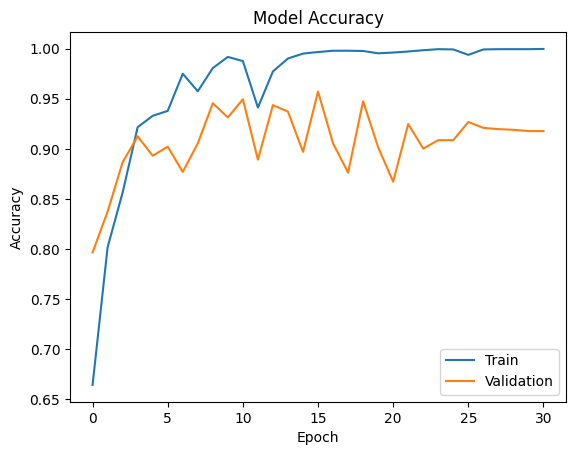

In [ ]:
import os
import zipfile
import shutil
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Path to the zip file and split ratios
path = "covid19normalpneumonia-ct-images.zip"
classesPath = ['Normal_CT', 'pneumonia_CT']
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# Extract and split data into train, val, and test
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Paths and counters
extracted_path = "/content/"
class_file_counts = {}

# First, gather the number of files in each class to find the minority class
for cls in classesPath:
    src = os.path.join(extracted_path, cls)
    allFileNames = os.listdir(src)
    class_file_counts[cls] = len(allFileNames)

# Find the minimum file count across all classes (the minority class)
min_files = min(class_file_counts.values())

# Ensure the output directories exist
for cls in classesPath:
    os.makedirs(os.path.join('./train/', cls), exist_ok=True)
    os.makedirs(os.path.join('./val/', cls), exist_ok=True)
    os.makedirs(os.path.join('./test/', cls), exist_ok=True)

    # Define the source path for class images
    src = os.path.join(extracted_path, cls)

    # Get list of all image file names in the class directory
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)  # Shuffle the file list to ensure randomness
    # Limit the file count to match the minority class
    balanced_FileNames = allFileNames[:min_files]  # Undersample to match the minority class

    # Calculate the split sizes
    total_files = len(balanced_FileNames)
    train_count = int(train_ratio * total_files)
    val_count = int(val_ratio * total_files)
    test_count = total_files - train_count - val_count  # Remaining files go to the test set

    # Split the filenames into training, validation, and test sets
    train_FileNames = balanced_FileNames[:train_count]
    val_FileNames = balanced_FileNames[train_count:train_count + val_count]
    test_FileNames = balanced_FileNames[train_count + val_count:]

    # Print statistics for each class
    print(f'Total {cls} after balancing: {total_files}')
    print(f'Training: {len(train_FileNames)}')
    print(f'Validation: {len(val_FileNames)}')
    print(f'Testing: {len(test_FileNames)}\n')

    # Copy files to their respective directories
    for name in train_FileNames:
        shutil.copy(os.path.join(src, name), os.path.join('./train/', cls))

    for name in val_FileNames:
        shutil.copy(os.path.join(src, name), os.path.join('./val/', cls))

    for name in test_FileNames:
        shutil.copy(os.path.join(src, name), os.path.join('./test/', cls))

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow data from directories
train_generator = train_datagen.flow_from_directory(
    './train', target_size=(128, 128), batch_size=32, class_mode='binary', shuffle=True, seed=90
)
val_generator = val_test_datagen.flow_from_directory(
    './val', target_size=(128, 128), batch_size=32, class_mode='binary', shuffle=False, seed=90
)
test_generator = val_test_datagen.flow_from_directory(
    './test', target_size=(128, 128), batch_size=32, class_mode='binary', shuffle=False, seed=90
)

# Calculate class weights
X_train_full, y_train_full = [], []
for i in range(train_generator.__len__()):
    X_batch, y_batch = train_generator.__getitem__(i)
    X_train_full.append(X_batch)
    y_train_full.append(y_batch)
X_train_full, y_train_full = np.concatenate(X_train_full), np.concatenate(y_train_full)

class_weights_dict = dict(enumerate(compute_class_weight(class_weight='balanced', classes=np.unique(y_train_full), y=y_train_full)))

# Model setup with InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=X_train_full.shape[1:])
for layer in base_model.layers[-30:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.6)(x)
y_hat = Dense(1, activation='sigmoid')(x)
model_InceptionV3 = Model(inputs=base_model.input, outputs=y_hat)

# Compile and fit the model
optimizer = Adam(learning_rate=1e-4)
loss = BinaryFocalCrossentropy(gamma=2.0)
model_InceptionV3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

history_InceptionV3 = model_InceptionV3.fit(
    X_train_full, y_train_full, epochs=50, batch_size=32, shuffle=True,
    validation_data=val_generator, callbacks=[early_stopping, reduce_lr], class_weight=class_weights_dict
)

# Validation metrics
val_preds = (model_InceptionV3.predict(val_generator) > 0.5).astype(int)
print(f'Validation - Accuracy: {accuracy_score(val_generator.classes, val_preds)}')
print(f'Precision: {precision_score(val_generator.classes, val_preds)}')
print(f'Recall: {recall_score(val_generator.classes, val_preds)}')
print(f'F1-Score: {f1_score(val_generator.classes, val_preds)}')

# Test metrics
X_test_full, y_test_full = [], []
for i in range(test_generator.__len__()):
    X_batch, y_batch = test_generator.__getitem__(i)
    X_test_full.append(X_batch)
    y_test_full.append(y_batch)
X_test_full, y_test_full = np.concatenate(X_test_full), np.concatenate(y_test_full)

test_preds = (model_InceptionV3.predict(X_test_full) > 0.5).astype(int)
print(f'\nTest Set - Accuracy: {accuracy_score(y_test_full, test_preds)}')
print(f'Precision: {precision_score(y_test_full, test_preds)}')
print(f'Recall: {recall_score(y_test_full, test_preds)}')
print(f'F1-Score: {f1_score(y_test_full, test_preds)}')

# Plot accuracy
plt.plot(history_InceptionV3.history['accuracy'])
plt.plot(history_InceptionV3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step


<Figure size 800x600 with 0 Axes>

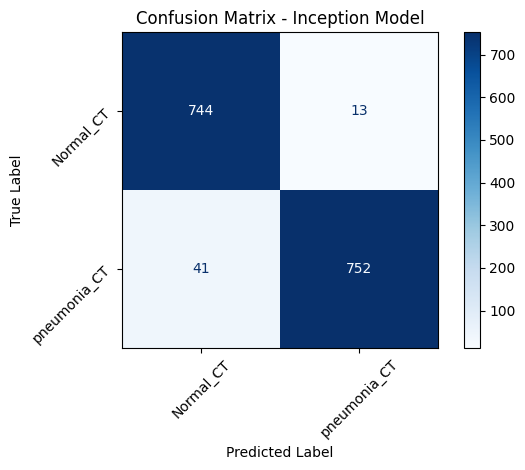

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate model on test data
predictions = model_InceptionV3.predict(test_generator)
y_pred = (predictions > 0.5).astype(int).ravel()  # Convert probabilities to class labels (0 or 1)

# True labels
y_true = test_generator.classes  # Assuming test_generator has the true labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Inception Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_InceptionV3.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3.h5')

In [ ]:
#implementation of Grad CAM

<ipython-input-13-521fb5509853>:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


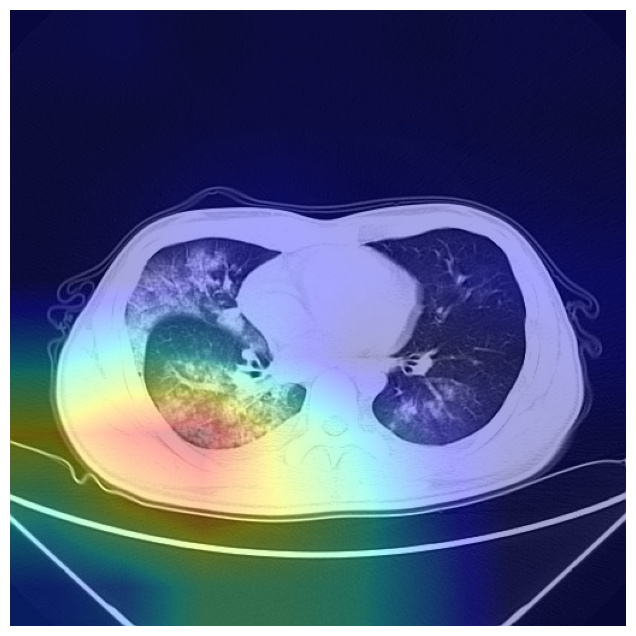

In [ ]:
#Implementation of Grad CAM on CT Scan images
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the InceptionV3 model
model = InceptionV3(weights="imagenet")

# Function to preprocess input image
def preprocess_image(img_path, target_size=(299, 299)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Grad-CAM function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradients of the top predicted class with respect to the output feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute the mean intensity of the gradients for each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each feature map by its corresponding gradient intensity
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU to the heatmap and normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to overlay the heatmap on the original image
def overlay_heatmap(heatmap, img_path, alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Resize heatmap to match image dimensions
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=2)
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1])).numpy()
    heatmap = np.uint8(heatmap)

    # Create a colored heatmap
    jet = plt.cm.get_cmap("jet")
    jet_heatmap = jet(np.arange(256))[:, :3]
    jet_heatmap = np.uint8(jet_heatmap * 255)
    colored_heatmap = jet_heatmap[heatmap[:, :, 0]]

    # Overlay the heatmap on the original image
    superimposed_img = colored_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

# Test with an example image
img_path = "/content/val/pneumonia_CT/102 (37).jpg"  # Replace with your image path
img_array = preprocess_image(img_path)

# Get Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="mixed10")

# Overlay heatmap on image
superimposed_img = overlay_heatmap(heatmap, img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()


<ipython-input-10-76d961ad0326>:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


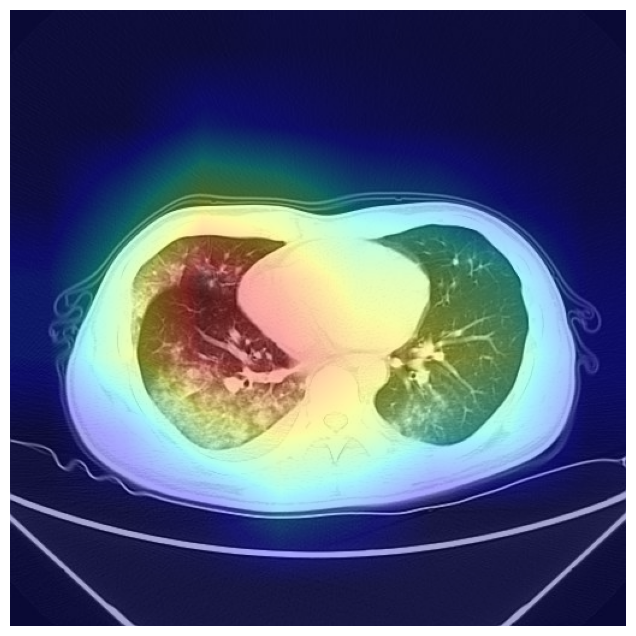

In [ ]:
img_path="/content/test/pneumonia_CT/102 (45).jpg"
img_array = preprocess_image(img_path)
# Get Grad-CAM heatmap
heatmap2 = make_gradcam_heatmap(img_array, model, last_conv_layer_name="mixed10")

# Overlay heatmap on image
superimposed_img = overlay_heatmap(heatmap2, img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()

<ipython-input-13-521fb5509853>:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


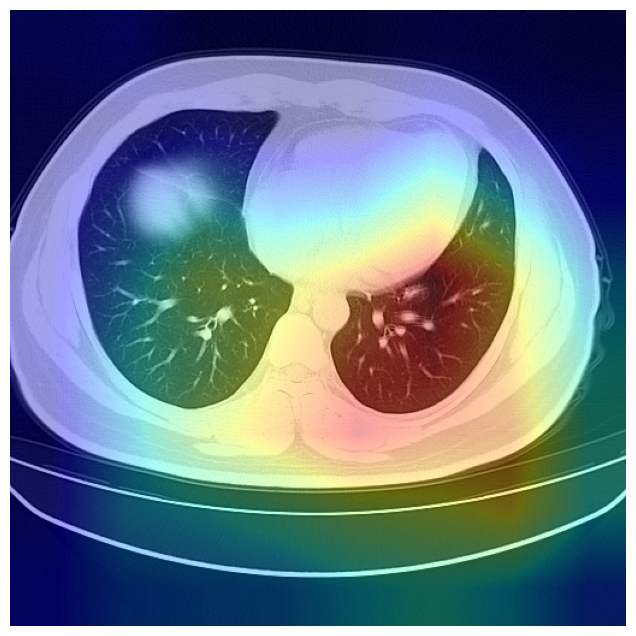

In [ ]:
img_path="/content/test/Normal_CT/23985k (9).jpg"
img_array = preprocess_image(img_path)
# Get Grad-CAM heatmap
heatmap3 = make_gradcam_heatmap(img_array, model, last_conv_layer_name="mixed10")

# Overlay heatmap on image
superimposed_img = overlay_heatmap(heatmap2, img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()

<ipython-input-13-521fb5509853>:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


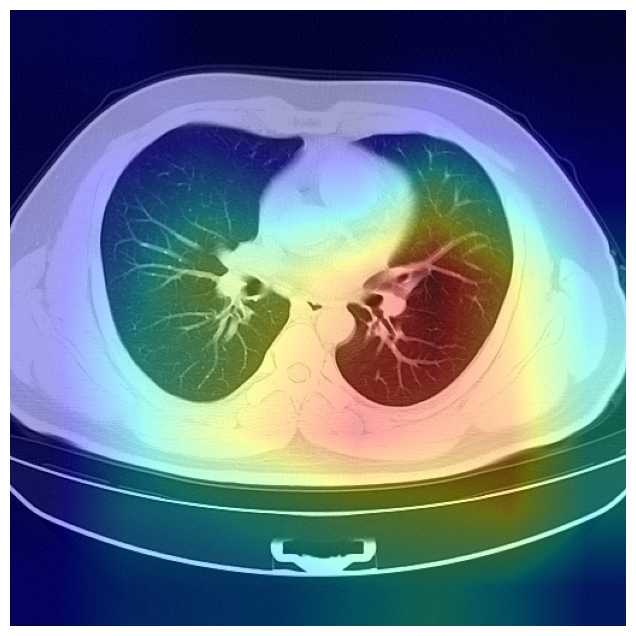

In [ ]:
img_path="/content/val/Normal_CT/23985k (26).jpg"
img_array = preprocess_image(img_path)
# Get Grad-CAM heatmap
heatmap4 = make_gradcam_heatmap(img_array, model, last_conv_layer_name="mixed10")

# Overlay heatmap on image
superimposed_img = overlay_heatmap(heatmap2, img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()

In [ ]:
#Implementation of CAM

<ipython-input-18-ac528c7dc67f>:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


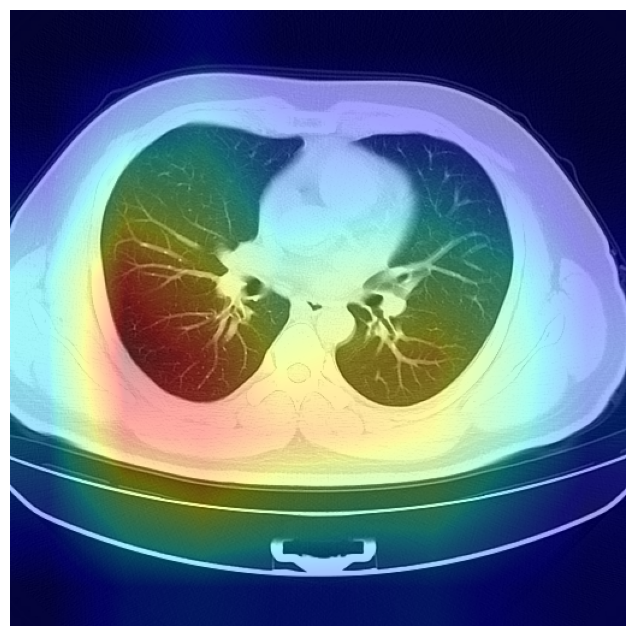

In [ ]:
#Implementation of CAM on CT Scan images
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the InceptionV3 model
# Ensure the model ends with a Global Average Pooling (GAP) layer
model = InceptionV3(weights="imagenet")

# Function to preprocess input image
def preprocess_image(img_path, target_size=(299, 299)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to compute Class Activation Mapping (CAM)
def compute_cam(img_array, model, last_conv_layer_name, class_idx=None):
    # Create a model that maps input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_model = tf.keras.models.Model(model.input, last_conv_layer.output)

    # Get the classification layer weights
    classifier_weights = model.layers[-1].get_weights()[0]  # Final dense layer weights

    # Compute the feature maps and predictions
    feature_maps = last_conv_model(img_array)
    predictions = model(img_array)

    if class_idx is None:
        class_idx = np.argmax(predictions[0])

    # Get the weights for the specific class
    class_weights = classifier_weights[:, class_idx]

    # Compute the weighted sum of feature maps
    cam = tf.reduce_sum(feature_maps[0] * class_weights, axis=-1)

    # Normalize CAM
    cam = tf.maximum(cam, 0)  # ReLU operation
    cam = cam / tf.reduce_max(cam)
    return cam.numpy()

# Function to overlay CAM on original image
def overlay_cam(cam, img_path, alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Resize CAM to the size of the original image
    cam = np.uint8(255 * cam)
    cam = tf.image.resize(np.expand_dims(cam, axis=-1), (img.shape[0], img.shape[1])).numpy()
    cam = np.uint8(cam[:, :, 0])

    # Create a colored heatmap
    jet = plt.cm.get_cmap("jet")
    jet_heatmap = jet(np.arange(256))[:, :3]
    jet_heatmap = np.uint8(jet_heatmap * 255)
    colored_heatmap = jet_heatmap[cam]

    # Overlay the heatmap on the image
    superimposed_img = colored_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

# Test with an example image
img_path = "/content/val/Normal_CT/23985k (26).jpg"  # Replace with your image path
img_array = preprocess_image(img_path)

# Get CAM heatmap
cam = compute_cam(img_array, model, last_conv_layer_name="mixed10")

# Overlay CAM on image
superimposed_img = overlay_cam(cam, img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()


<ipython-input-18-ac528c7dc67f>:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


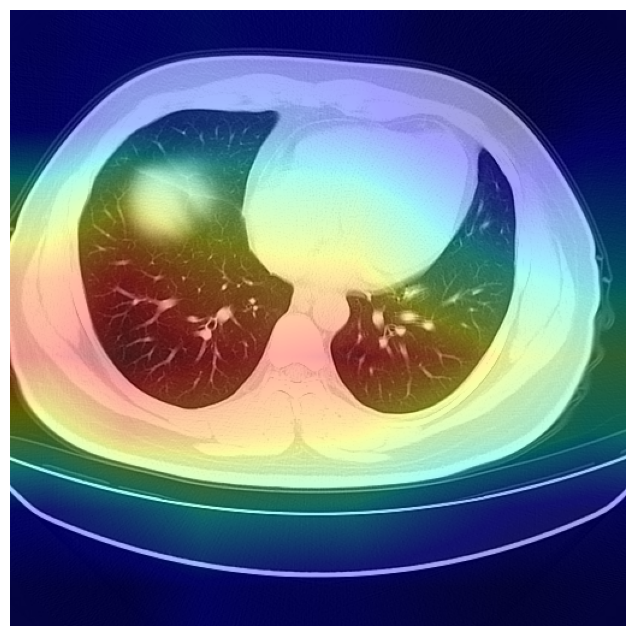

In [ ]:
img_path="/content/test/Normal_CT/23985k (9).jpg"
img_array = preprocess_image(img_path)

# Get CAM heatmap
cam = compute_cam(img_array, model, last_conv_layer_name="mixed10")

# Overlay CAM on image
superimposed_img = overlay_cam(cam, img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()


<ipython-input-18-ac528c7dc67f>:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


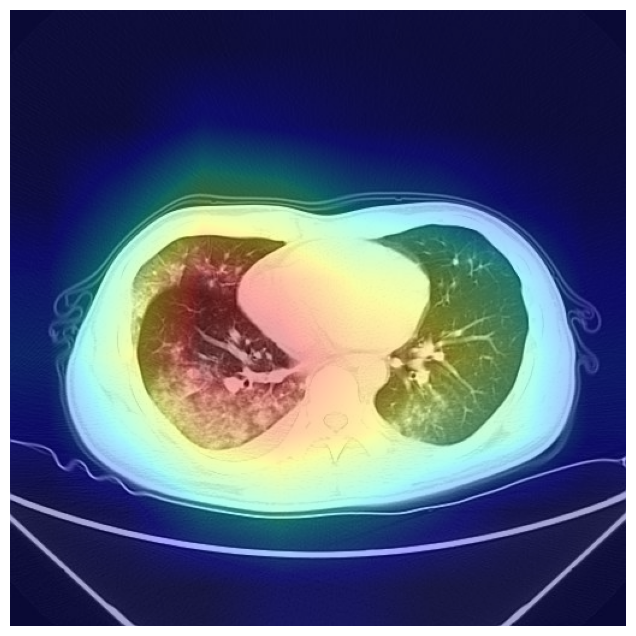

In [ ]:
img_path="/content/test/pneumonia_CT/102 (45).jpg"
img_array = preprocess_image(img_path)

# Get CAM heatmap
cam = compute_cam(img_array, model, last_conv_layer_name="mixed10")

# Overlay CAM on image
superimposed_img = overlay_cam(cam, img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()


<ipython-input-18-ac528c7dc67f>:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


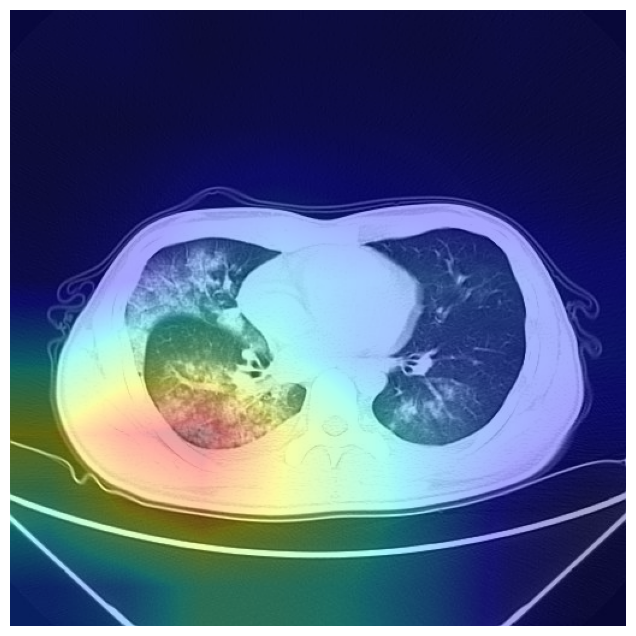

In [ ]:
img_path="/content/val/pneumonia_CT/102 (37).jpg"
img_array = preprocess_image(img_path)

# Get CAM heatmap
cam = compute_cam(img_array, model, last_conv_layer_name="mixed10")

# Overlay CAM on image
superimposed_img = overlay_cam(cam, img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()


In [ ]:
pip install lime

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load the pretrained model (e.g., InceptionV3)
model = InceptionV3(weights="imagenet")

# Function to preprocess input image
def preprocess_image(img_path, target_size=(299, 299)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to make predictions
def predict(images):
    images = preprocess_input(images)
    return model.predict(images)

# LIME explainer for images
def explain_image_with_lime(img_path):
    # Load and preprocess the image
    img_array = preprocess_image(img_path)[0]  # Remove batch dimension for LIME
    img = image.img_to_array(image.load_img(img_path))

    # Initialize the LIME image explainer
    explainer = lime_image.LimeImageExplainer()

    # Explain the image prediction
    explanation = explainer.explain_instance(
        img_array.astype('double'),
        predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000  # Number of perturbed samples
    )

    # Get explanation for the top predicted class
    top_pred_class = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_pred_class,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # Visualize the explanation
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img / 255.0)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.axis("off")
    plt.title(f"LIME Explanation (Class {top_pred_class})")

    plt.show()

# Test with an example image
img_path = "elephant.jpg"  # Replace with your image path
explain_image_with_lime(img_path)
